In [6]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
import copy
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [7]:
"""
Parse the input file, return a list [ list of features ] and list of labels : 1 or -1 
"""

def parseFile(file_name):
    features = []
    labels = []
    f = open(file_name, 'r')
    number_columns = len(f.readline().split(","))
    c = 0
    for line in f:
        c += 1
        array_row = line.split(",")
        x = []
        
        for i in range(number_columns - 2):
            x += [float(array_row[i])]        
        features += [x]
        if int(array_row[number_columns - 1]) == 0:
            labels += [-1] 
        else:
            labels += [1]
        
    return features, labels

features, labels = parseFile("spambase.data.shuffled")
features = scale(np.array(features))
labels = np.array(labels)

trainFeatures, trainLabels = features[:3450], labels[:3450]
testFeatures, testLabels = features[-1150:], labels[-1150:]
print trainFeatures.shape, testFeatures.shape

(3450, 56) (1150, 56)


In [8]:
class Adaboost:
    """
    D : Dictionnary of weights D[i] = list of m weights
    """
    D = np.empty(0)
        
    """
    alpha_list : List of alphas of the Adaboost best h
    """
    alpha_list = np.empty(0)
    
    """
    h_list : List of h_t best classifiers selected
    """
    h_list = np.empty(0)
    
    """
    T : number of iterations
    """
    T = 0
    
    """
    decisionTreeClassifier : Decision tree classifier
    """
    decisionTreeClassifier = 0
    
    def __init__(self, T):
        
        self.D = np.empty(0)
        self.alphas = np.empty(0)
        self.h_t = np.empty(0)
        self.T = T
        self.decisionTreeClassifier = DecisionTreeClassifier(criterion="entropy", max_depth=1, presort=True)
        
    def fit(self, trainFeatures, trainLabels):
        error_rate = []
        feat = []
        
        """
        fit Adaboost to the training set, with T iterations.
        """
        
        m, n = trainFeatures.shape
        
        self.D[0] = np.zeros(m)
        self.D[0].fill(1.0 / m)

        for t in range(self.T):
            h_t = self.decisionTreeClassifier.fit(trainFeatures, trainLabels, self.D[t])
            
            h_t_predict_all = h_t.predict(trainFeatures)
            
            epsilon_t =  np.where(h_t_predict_all * trainLabels == -1, 1.0, 0) * self.D[t]
            epsilon_t = epsilon_t.sum()
            
            alpha_t = np.log((1 - epsilon_t) / epsilon_t) / 2
            Z_t = 2 * np.sqrt(epsilon_t * ( 1 - epsilon_t))
                        
            self.D[t + 1] =  self.D[t] * np.exp(- alpha_t * trainLabels * h_t_predict_all) / Z_t
                            
            if len(self.alpha_list) > 0 and self.alpha_list[-1] == alpha_t:
                print " Stoping the training at t = {0}, convergence.".format(t)
                break
            
            error_rate += [epsilon_t]
            feat += [np.argmax(h_t.feature_importances_)]
            self.alpha_list = np.append(self.alpha_list, alpha_t)
            self.h_list = np.append(self.h_list, copy.copy(h_t))
    
    def predict(self, x, T):
        """
        Once trained, predict a label given x
        T : if we compute adaboost(1000) and we want adaboost(10), it's the 10 first terms of adaboost(1000). Let's use it.
        """        
        scores = np.zeros(x.shape[0])
        for i in range(T):
            scores = scores + self.alpha_list[i] * self.h_list[i].predict(x)
        return np.where(scores > 0, 1, -1)
    
    def error(self, x, y, T):
        """
        Return the percentage of errors in the prediction.
        """
        return np.where(self.predict(x, T) * y == 1, 0, 1).sum() * 1.0 / x.shape[0]
    
    def toString(self):
        print "T : {0}, Alphas : {0}".format(self.T, len(self.alpha_list))

In [9]:
# Tests :
myAdaboost = Adaboost(10)
myAdaboost.fit(trainFeatures, trainLabels)
print " Errors : {0}".format(myAdaboost.error(features, labels, 5))

 Errors : 0.125217391304


In [10]:
from sklearn.cross_validation import KFold

kf = KFold(n=trainFeatures.shape[0], n_folds=10, shuffle=True)

In [ ]:
Tmax = 10000

T_errors = {}
for t in range(Tmax):
    T_errors[t] = []

for train_index, test_index in kf:
    print " One KFold."
    myAdab = Adaboost(Tmax)
    myAdab.fit(trainFeatures[train_index], trainLabels[train_index])
    print " Errors"
    for t in range(0, Tmax, 5):
        T_errors[t] += [myAdab.error(trainFeatures[test_index], trainLabels[test_index], t)]

 One KFold.
 Errors
 One KFold.
 Errors
 One KFold.
 Errors
 One KFold.
 Errors
 One KFold.
 Errors
 One KFold.
 Errors
 One KFold.
 Errors


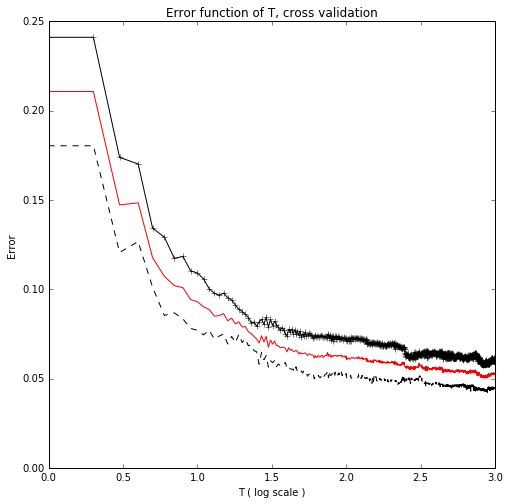

In [19]:
error_plus = []
error_mean = []
error_minus = []
log_t = np.log10(T_errors.keys())

for t in T_errors.keys():
    array = np.array(T_errors[t])
    mean = array.mean()
    stddout = array.std()
    error_plus += [mean + stddout]
    error_mean += [mean]
    error_minus += [mean - stddout]

plt.figure(figsize=(8,8))
plt.title("Error function of T, cross validation")
plt.xlabel("T ( log scale )")
plt.ylabel("Error")
plt.plot(log_t,error_plus, "k-+", label="mean(error) + std")
plt.plot(log_t,error_mean, "r", label="mean(error)")
plt.plot(log_t,error_minus, "k--", label="mean(error) - std")
plt.show()

In [15]:
k = 3
Ts = [i for i in range(1, 10**k + 1)]

Train_error = []
Test_error = []
print " Fitting ... "
adaboost = Adaboost(Ts[-1])
adaboost.fit(trainFeatures, trainLabels)
print " Computing errors ..."  
for T in Ts:
    Train_error += [adaboost.error(trainFeatures, trainLabels, T)]
    Test_error += [adaboost.error(testFeatures, testLabels, T)]

 Fitting ... 
 Computing errors ...


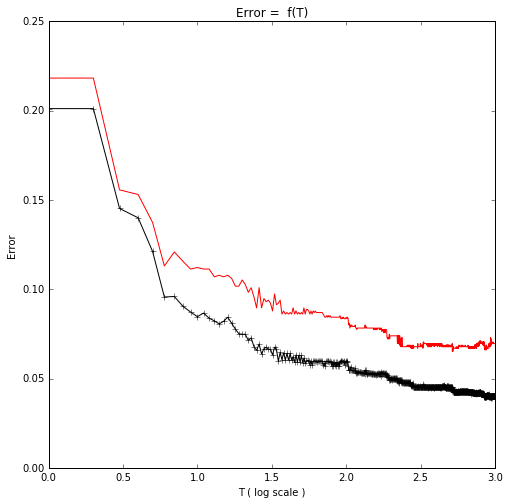

In [16]:
from matplotlib.legend_handler import HandlerLine2D

log_t = np.log10(Ts)
plt.figure(figsize=(8,8))
plt.title("Error =  f(T)")
plt.xlabel("T ( log scale )")
plt.ylabel("Error")
line1 = plt.plot(log_t, Train_error, "k-+", label="Train error")
l2 = plt.plot(log_t, Test_error, "r", label="Test error")
plt.show()